# Tarea : Modelo Arima
- Profesor: Pedro Martinez
- Alumnno: Ivan Morales

11 de Febrero de 2026

### Parte 1 de la tarea:

	
1) Utilizando como base la forma canónica de un modelo ARIMA(p,d,q), desarrollar el caso en el que se considera un modelo de orden ARIMA(2,1,2).

Forma Canonica:

$$
\phi(L) (1 - L)^d y_t = c + \theta(L) \epsilon_t
$$

Con ARIMA(2,1,2)

\begin{align*}
p &= 1 - \phi_1 L - \phi_2 L^2 \\
d &= (1-L)^1 \\ 
q &= 1 + \theta_1 L + \theta_2 L^2
\end{align*}

Sustituimos y Desarrollamos

\begin{align*}
(1 - \phi_1 L - \phi_2 L^2 )(1 - L)y_t &= c + (1 + \theta_1 L + \theta_2 L^2) \epsilon_t \\
(1 - \phi_1 L - \phi_2 L^2 )(y_t - Ly_t) &= c + (\epsilon_t + \epsilon_t\theta_1 L + \epsilon_t\theta_2 L^2) \\
y_t - \phi_1 L y_t - \phi_2 L^2 y_t - L y_t + \phi_1 L^2 y_t + \phi_2 L^3 y_t &= c + \epsilon_t + \epsilon_t\theta_1 L + \epsilon_t\theta_2 L^2 \\
y_t &= c + \epsilon_t + \epsilon_{t-1}\theta_1 + \epsilon_{t-2}\theta_2 + \phi_1 L y_t + \phi_2 L^2 y_t + L y_t - \phi_1 L^2 y_t - \phi_2 L^3 y_t
\end{align*}

Utilizamos el operador rezago donde:

\begin{align*}
L y_t = y_{t-1} \\ 
L^2 y_t = y_{t-2} \\ 
L \epsilon_t = \epsilon_{t-1}
\end{align*}

\begin{align}
y_t &= c + \epsilon_t + \epsilon_{t-1}\theta_1 + \epsilon_{t-2}\theta_2 + \phi_1 y_{t-1} + \phi_2 y_{t-2} + y_{t-1} - \phi_1 y_{t-2} - \phi_2 y_{t-3}
\end{align}

Ordenamos:

\begin{align}
y_t &= c + y_{t-1} + \phi_1 y_{t-1} - \phi_1 y_{t-2} + \phi_2 y_{t-2} - \phi_2 y_{t-3} + \epsilon_t + \epsilon_{t-1}\theta_1 + \epsilon_{t-2}\theta_2
\end{align}

Y reducimos terminos:

\begin{align}
y_t &= c + (1 + \phi_1)y_{t-1} + (- \phi_1 + \phi_2) y_{t-2} - \phi_2 y_{t-3} + \epsilon_t + \epsilon_{t-1}\theta_1 + \epsilon_{t-2}\theta_2
\end{align}

Para la realizacion del modelo ARIMA utilizaremos 3 librerias de python.

- Statsmodels (usado en la clase del lunes)
- Pmdarima
- Sklearn

In [7]:
# Importacion de Librerias 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from fredapi import Fred
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Modelo con statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Configuración de gráficos
plt.style.use('ggplot')

In [8]:
# Al igual que en la practica realizada en el laboratori usaremos FRED para obtener los datos que usaremos
# en este caso usaremos el indicador CARGSP que corresponde a Real Gross Domestic Product: All Industry Total in California.

# @title Conexión a FRED (Federal Reserve Economic Data)



# IMPORTANTE:
# Puedes obtener API KEY en: https://fred.stlouisfed.org/docs/api/api_key.html
# La guardas como secret
# from google.colab import userdata

import os
from dotenv import load_dotenv

load_dotenv()  # Carga las variables de entorno desde el archivo .env   
API_KEY = os.getenv('API_KEY') # Aqui pon tu API

try:
    fred = Fred(api_key=API_KEY)

    # Usaremos 'CARGSP'.
    series_id = 'CARGSP'
    df = pd.DataFrame(fred.get_series(series_id), columns=['value'])
    df.index.name = 'date'

    # Filtramos datos desde el año 1960 para un análisis más reciente
    df = df[df.index >= '1960-01-01']

    # IMPORTANTE: Establecemos la frecuencia anual
    df.index = pd.DatetimeIndex(df.index).to_period('M').to_timestamp()
    df.index.freq = 'YS'

except Exception as e:
    print(f"Error: {e}")

fig = px.line(df, x=df.index, y='value', title=f'Serie de Tiempo: {series_id}')
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Índice',

)
fig.show()

In [6]:
# @title Prueba de Dickey-Fuller y Diferenciación
def check_stationarity(series, title="Serie Original"):
    result = adfuller(series.dropna())
    print(f'ADF Test: {title}')
    print(f'Estadístico ADF: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    is_stationary = result[1] < 0.05
    print(f"¿Es estacionaria? {'SÍ' if is_stationary else 'NO'}\n")
    return is_stationary

# 1. Revisamos la serie original
check_stationarity(df['value'], "Nivel Original")

# 2. Aplicamos Primera Diferencia (d=1)
df['diff_1'] = df['value'].diff()

# 3. Revisamos la serie diferenciada
check_stationarity(df['diff_1'], "Primera Diferencia (d=1)")

# Creamos una figura con 2 columnas (Subplots)
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Serie Original (No Estacionaria)", "Serie Diferenciada (Estacionaria d=1)")
)

# Gráfico 1: Serie Original
fig.add_trace(
    go.Scatter(x=df.index, y=df['value'], name='Original'),
    row=1, col=1
)

# Gráfico 2: Serie Diferenciada
fig.add_trace(
    go.Scatter(x=df.index, y=df['diff_1'], name='Diferenciada'),
    row=1, col=2
)

# Ajustes de diseño
fig.update_layout(
    title_text="Comparativa: Efecto de la Diferenciación",
    showlegend=False, # Ocultamos leyenda
    height=500
)

fig.show()

ADF Test: Nivel Original
Estadístico ADF: 1.1027
p-value: 0.9952
¿Es estacionaria? NO

ADF Test: Primera Diferencia (d=1)
Estadístico ADF: -5.4184
p-value: 0.0000
¿Es estacionaria? SÍ



Notamos que con una sola diferenciacion nuestra serie se vuelve estacionaria, usaremos orden $D = 1$.

A continuacion realizare los correlogramas $PACF$ y $ACF$, para determinar orden $P$ y $Q$

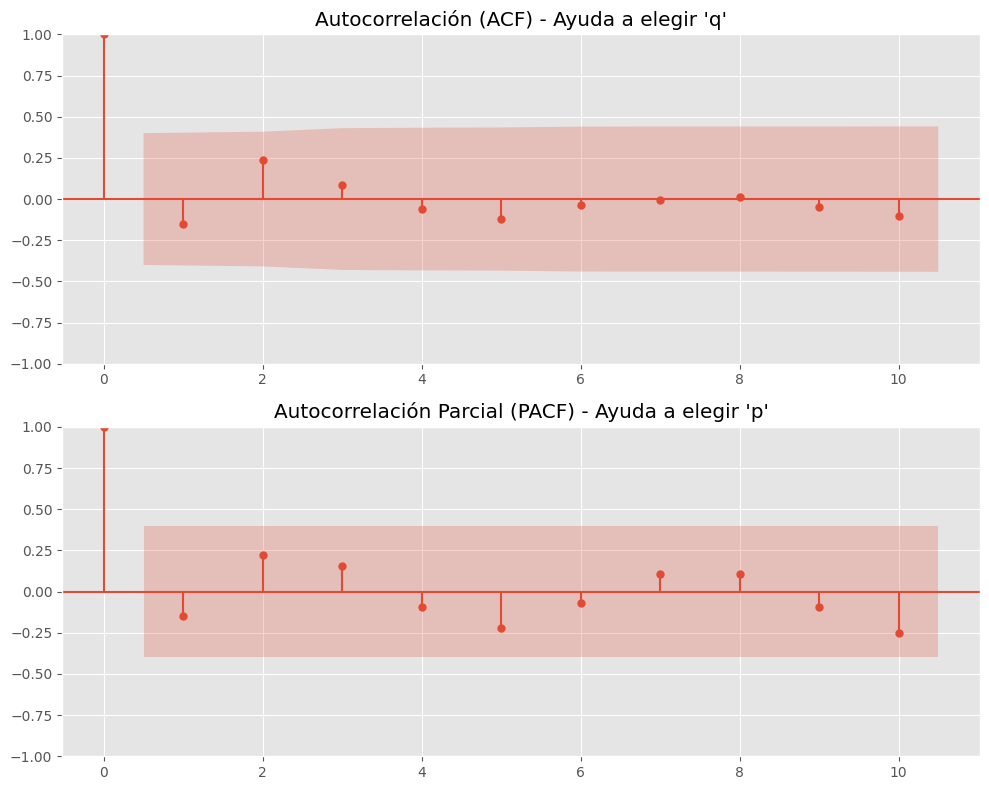

In [7]:
# @title Gráficos ACF y PACF
# IMPORTANTE: Usamos la serie diferenciada
series_analysis = df['diff_1'].dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Graficamos ACF (para q)
plot_acf(series_analysis, lags=10, ax=ax1, title="Autocorrelación (ACF) - Ayuda a elegir 'q'")

# Graficamos PACF (para p)
plot_pacf(series_analysis, lags=10, ax=ax2, title="Autocorrelación Parcial (PACF) - Ayuda a elegir 'p'")

plt.tight_layout()
plt.show()

Basandonos en las graficas que obtuvimos podemos determinar que seria buena idea usar un modelo:

$ARIMA(1, 1, 1)$ 

Aunque trataremos tambien con uno:

$ARIMA(2, 1, 1)$

Y compararemos los resultados.

# Modelo (1, 1, 1)

In [8]:
# @title Realizar modelo ARIMA


# Definimos el tamaño del test
test_size = 6

# Separamos los datos
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]


# Ajustamos el modelo ARIMA
# Nota: Statsmodels maneja la diferenciación (d=1) internamente.
model = ARIMA(train['value'], order=(1, 1, 1))
results = model.fit()
print(results.summary())

# Realizamos el pronóstico para los pasos del Test set
# start: índice donde empieza el test, end: índice donde termina
forecast_object = results.get_forecast(steps=len(test))
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int(alpha=0.05) # 95% confianza

# Convertimos a DataFrame para facilitar el manejo
forecast_df = pd.DataFrame({
    'date': test.index,
    'actual': test['value'],
    'forecast': forecast.values,
    'lower_ci': conf_int.iloc[:, 0].values,
    'upper_ci': conf_int.iloc[:, 1].values
})
forecast_df.set_index('date', inplace=True)

# Cálculo de Métricas de Error
rmse = np.sqrt(mean_squared_error(test['value'], forecast))
mae = mean_absolute_error(test['value'], forecast)
print(f"\n--- Métricas de Evaluación en Test Set ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


fig = go.Figure()
# Datos de Entrenamiento (Histórico)
# Mostramos solo los últimos años para que se vea bien el detalle del final
train_subset = train[train.index > '2018-01-01']

fig.add_trace(go.Scatter(
    x=train_subset.index, y=train_subset['value'],
    mode='lines', name='Train',
    line=dict(color='gray')
))

# Datos Reales (Test)
fig.add_trace(go.Scatter(
    x=test.index, y=test['value'],
    mode='lines+markers', name='Test',
    line=dict(color='green', width=2)
))

# Pronóstico del Modelo
fig.add_trace(go.Scatter(
    x=forecast_df.index, y=forecast_df['forecast'],
    mode='lines+markers', name='ARIMA',
    line=dict(color='red', dash='dash', width=2)
))

# Intervalos de Confianza
fig.add_trace(go.Scatter(
    x=forecast_df.index.tolist() + forecast_df.index[::-1].tolist(),
    y=forecast_df['upper_ci'].tolist() + forecast_df['lower_ci'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.15)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Intervalo de Confianza (95%)',
    hoverinfo="skip"
))

fig.update_layout(
    title='Real vs Forecast',
    xaxis_title='Fecha',
    yaxis_title='Indice',
    hovermode="x unified",
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   19
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -219.088
Date:                Wed, 11 Feb 2026   AIC                            444.176
Time:                        21:02:31   BIC                            446.847
Sample:                    01-01-2000   HQIC                           444.544
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.011     88.487      0.000       0.978       1.022
ma.L1         -0.9987      0.291     -3.433      0.001      -1.569      -0.429
sigma2      2.096e+09   1.27e-10   1.65e+19      0.0

c:\Users\ivanm\6toSemestre\modelos_no_lineales\arima_models\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



# Modelo (2, 1, 1)

In [9]:
# @title Realizar modelo ARIMA


# Definimos el tamaño del test
test_size = 6

# Separamos los datos
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]


# Ajustamos el modelo ARIMA
# Nota: Statsmodels maneja la diferenciación (d=1) internamente.
model = ARIMA(train['value'], order=(2, 1, 1))
results = model.fit()
print(results.summary())

# Realizamos el pronóstico para los pasos del Test set
# start: índice donde empieza el test, end: índice donde termina
forecast_object = results.get_forecast(steps=len(test))
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int(alpha=0.05) # 95% confianza

# Convertimos a DataFrame para facilitar el manejo
forecast_df = pd.DataFrame({
    'date': test.index,
    'actual': test['value'],
    'forecast': forecast.values,
    'lower_ci': conf_int.iloc[:, 0].values,
    'upper_ci': conf_int.iloc[:, 1].values
})
forecast_df.set_index('date', inplace=True)

# Cálculo de Métricas de Error
rmse = np.sqrt(mean_squared_error(test['value'], forecast))
mae = mean_absolute_error(test['value'], forecast)
print(f"\n--- Métricas de Evaluación en Test Set ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


fig = go.Figure()
# Datos de Entrenamiento (Histórico)
# Mostramos solo los últimos años para que se vea bien el detalle del final
train_subset = train[train.index > '2018-01-01']

fig.add_trace(go.Scatter(
    x=train_subset.index, y=train_subset['value'],
    mode='lines', name='Train',
    line=dict(color='gray')
))

# Datos Reales (Test)
fig.add_trace(go.Scatter(
    x=test.index, y=test['value'],
    mode='lines+markers', name='Test',
    line=dict(color='green', width=2)
))

# Pronóstico del Modelo
fig.add_trace(go.Scatter(
    x=forecast_df.index, y=forecast_df['forecast'],
    mode='lines+markers', name='ARIMA',
    line=dict(color='red', dash='dash', width=2)
))

# Intervalos de Confianza
fig.add_trace(go.Scatter(
    x=forecast_df.index.tolist() + forecast_df.index[::-1].tolist(),
    y=forecast_df['upper_ci'].tolist() + forecast_df['lower_ci'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.15)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Intervalo de Confianza (95%)',
    hoverinfo="skip"
))

fig.update_layout(
    title='Real vs Forecast',
    xaxis_title='Fecha',
    yaxis_title='Indice',
    hovermode="x unified",
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   19
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -218.499
Date:                Wed, 11 Feb 2026   AIC                            444.999
Time:                        21:02:41   BIC                            448.560
Sample:                    01-01-2000   HQIC                           445.490
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9709      0.105      9.241      0.000       0.765       1.177
ar.L2          0.0290      0.110      0.264      0.792      -0.187       0.245
ma.L1         -0.9975      0.271     -3.677      0.0

c:\Users\ivanm\6toSemestre\modelos_no_lineales\arima_models\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



El modelo mejora cuando hacemos (2, 1, 1), ahora haremos uso de la libreria Pmdarima.

# Pmdarima

In [48]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

model_pm = pm.ARIMA(order=(2, 1, 1))
print(model_pm)

 ARIMA(2,1,1)(0,0,0)[0] intercept


c:\Users\ivanm\6toSemestre\modelos_no_lineales\arima_models\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\ivanm\6toSemestre\modelos_no_lineales\arima_models\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



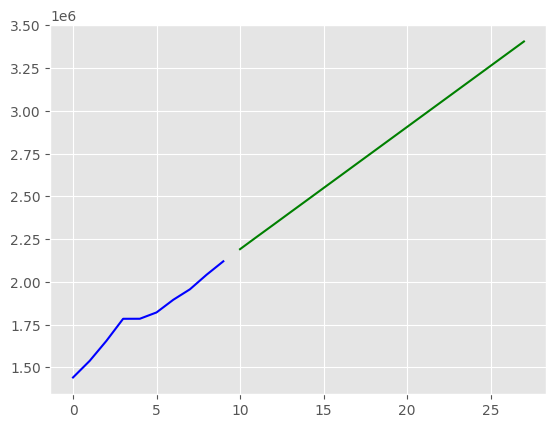

In [49]:
# Load/split your data
y = df['value'].values
train, test = train_test_split(y, train_size=10)

# Fit your model
model_pm.fit(train)

# make your forecasts
forecasts = model_pm.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:10], train, c='blue')
plt.plot(x[10:], forecasts, c='green')
plt.show()

In [50]:
print(f"Model Summary with Pmdarima: {model_pm.summary()}")

Model Summary with Pmdarima:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   10
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -114.500
Date:                Wed, 11 Feb 2026   AIC                            239.000
Time:                        21:24:53   BIC                            239.986
Sample:                             0   HQIC                           236.872
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.207e+05   2.56e+04      4.720      0.000    7.06e+04    1.71e+05
ar.L1         -0.6982      0.401     -1.741      0.082      -1.484       0.088
ar.L2          0.0080  

C:\Users\ivanm\AppData\Local\Temp\ipykernel_11244\117459968.py:20: FutureWarning:

The `regressor` argument is deprecated and will be removed in a future version. Please use `estimator` instead.



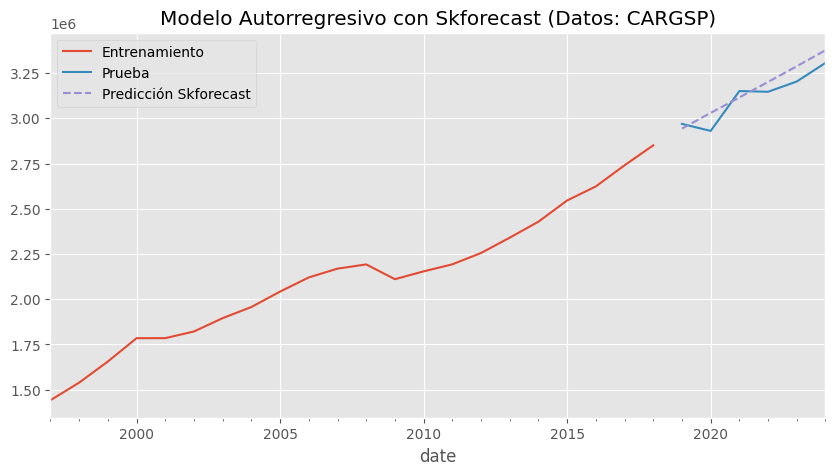

Error absoluto medio (MAE): 61634.32


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.recursive import ForecasterRecursive
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# 1. Preparación de datos (usando el DataFrame 'df' que ya tienes de FRED)
# Skforecast requiere que el índice sea Datetime con frecuencia definida
data = df.copy()
data = data.asfreq('YS') # Aseguramos frecuencia Year-Start

# 2. Dividir en entrenamiento y prueba
steps = 6
data_train = data[:-steps]
data_test  = data[-steps:]

# 3. Crear y entrenar el forecaster
# Usamos LinearRegression para que se comporte como un modelo AR(p)
# lags=2 significa que usará los 2 años anteriores para predecir el siguiente
forecaster = ForecasterRecursive(
                regressor = LinearRegression(),
                lags      = 2
             )

forecaster.fit(y=data_train['value'])

# 4. Predicción
predicciones = forecaster.predict(steps=steps)

# 5. Gráfico de resultados
fig, ax = plt.subplots(figsize=(10, 5))
data_train['value'].plot(ax=ax, label='Entrenamiento')
data_test['value'].plot(ax=ax, label='Prueba')
predicciones.plot(ax=ax, label='Predicción Skforecast', linestyle='--')
ax.set_title("Modelo Autorregresivo con Skforecast (Datos: CARGSP)")
ax.legend()
plt.show()

# 6. Métrica
error = mean_absolute_error(data_test['value'], predicciones)
print(f"Error absoluto medio (MAE): {error:.2f}")

### Comparacion de Modelos

MAE:

- Statsmodels = = 68043.4415
- Sklearn = 61634.32

Los resultados con Sklearn fueron mejores sin embargo considero que la implementacion con Statsmodels nos brinda mayor interpretabilidad.

Yo en lo personal me quedo con la opcion de statsmodels